### Investing some 1D cases

In [1]:
%matplotlib inline

In [182]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import time

### ADT

In [3]:
adt_data = pd.read_csv('/ye/yelabstore2/mincheol/data/scrna-parameter-estimation/raw/adt.csv')

In [34]:
adt_data.columns

Index(['CD14', 'CD19', 'CD45', 'CD4', 'CD8A'], dtype='object')

In [122]:
adt_counts = adt_data['CD14']
# cd45 = cd45[cd45 < 1000]

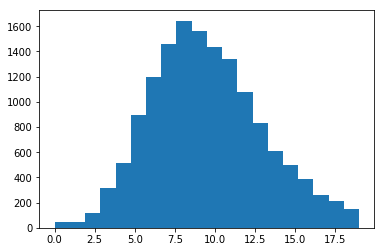

In [124]:
plt.hist(adt_counts[adt_counts < 20], bins=20);

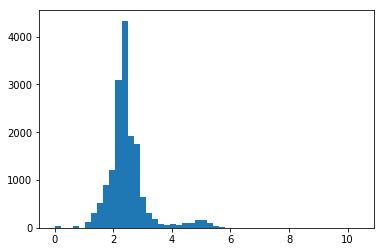

In [153]:
plt.hist(np.log(cd8a_adt + 1), bins=50);

### mRNA

In [126]:
transcript_data = pd.read_csv('/ye/yelabstore2/mincheol/data/scrna-parameter-estimation/raw/mrna.csv')

In [136]:
cd8a_mrna = transcript_data['CD8A']

In [137]:
cd8a_mrna.value_counts()

0    11442
1      927
2      237
3       65
4        9
5        2
6        1
9        1
Name: CD8A, dtype: int64

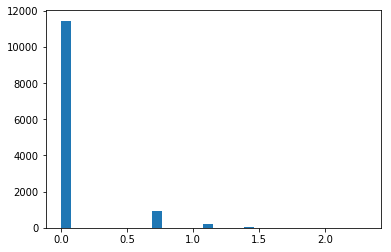

In [152]:
plt.hist(np.log(cd8a_mrna+1), bins=30);

### Simulation - very large underlying counts

Lets say the underlying distribution is mean 10 with variance 2.

In [43]:
num_cells = 10000
p = 0.1

In [44]:
sim_truth = np.random.normal(10, 2, size=num_cells)

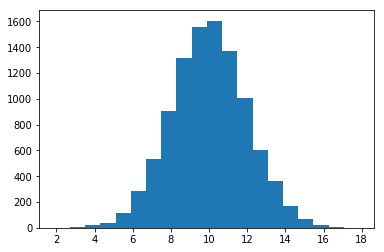

In [45]:
plt.hist(sim_truth, bins=20);

In [46]:
binom_observed = []
for cell in sim_truth[sim_truth >=0]:
    binom_observed.append(np.random.binomial(int(cell), p))
binom_observed = np.array(binom_observed)

In [47]:
normal_observed = []
for cell in sim_truth:
    mean = cell*p
    std = np.sqrt(cell*p*(1-p))
    normal_observed.append(np.random.normal(cell*p, std))
normal_observed = np.array(normal_observed)

In [48]:
binom_observed

array([1, 0, 0, ..., 1, 1, 1])

In [49]:
normal_observed

array([1.51835589, 2.12576824, 1.07728062, ..., 0.64802646, 1.36940978,
       0.58915555])

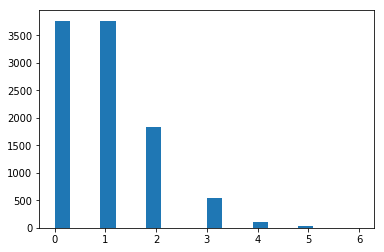

In [50]:
plt.hist(binom_observed, bins=20);

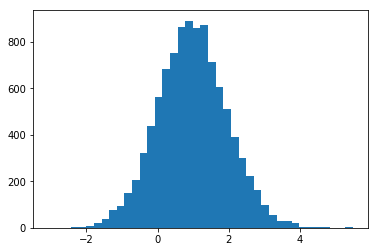

In [51]:
plt.hist(normal_observed, bins=40);

### 1D Likelihood Function

In [204]:
import scipy.stats as stats

In [205]:
def likelihood(p, mu, sigma, val):
    
    lh = 0
    for n in range(50):
        lh += stats.binom.pmf(val, n, p) * stats.norm.pdf(n, mu, sigma)
    return np.log(lh).sum()

In [206]:
likelihood(1.0, 5, 1, [5, 4, 5])

-3.256815599614018

### Brute force grid search

In [231]:
num_cells = 10000
p = 0.1
mu = 10
sigma = 2

In [232]:
sim_truth = np.random.normal(mu, sigma, size=num_cells)

In [233]:
binom_observed = []
for cell in sim_truth[sim_truth >=0]:
    binom_observed.append(np.random.binomial(int(cell), p))
binom_observed = np.array(binom_observed)

In [234]:
stats.norm.fit(sim_truth)

(9.991720207614717, 2.005072802699221)

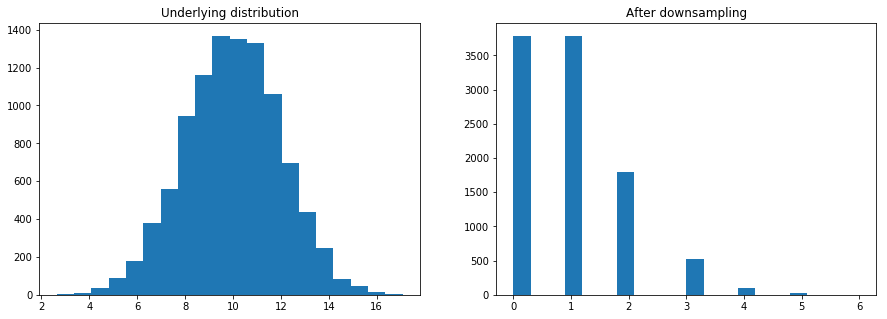

In [235]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1);
plt.title('Underlying distribution')
plt.hist(sim_truth, bins=20);
plt.subplot(1, 2, 2);
plt.title('After downsampling')
plt.hist(binom_observed, bins=20);

In [236]:
p_cand = np.arange(0.02, 0.2, 0.02)
mu_cand = np.arange(5, 15, 1)
sigma_cand = np.arange(.0, 3.0, 0.2)

In [237]:
results = []
for p, mu, sigma in itertools.product(p_cand, mu_cand, sigma_cand):
    results.append((p, mu, sigma, likelihood(p, mu, sigma, binom_observed)))
results = pd.DataFrame(results, columns=['p', 'mu', 'sigma', 'log_likelihood'])\
    .sort_values('log_likelihood', ascending=False)

In [248]:
print('Top parameters if we had an accurate mean:')
results.query('mu == 10').head(5)

If we had an accurate mean:


,p,mu,sigma,log_likelihood
455,0.1,10,2.0,-12582.491198
454,0.1,10,1.8,-12582.598059
456,0.1,10,2.2,-12582.733354
453,0.1,10,1.6,-12582.963630
457,0.1,10,2.4,-12583.446180


In [252]:
print('Top parameters if we didn\'t have an accurate mean:')
results.head(5)

Top parameters if we didn't have an accurate mean:


,p,mu,sigma,log_likelihood
373,0.08,12,1.6,-12566.537816
374,0.08,12,1.8,-12566.568674
372,0.08,12,1.4,-12566.610606
535,0.12,8,2.0,-12566.625604
375,0.08,12,2.0,-12566.741074
